MFC group analysis

In [46]:
import warnings; warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection

user defined variables

In [47]:
atlas = 'schaefer2018'
strat = 'HMPWMCSFScrubGS'
run = 'mean'
cmap = 'RdBu_r'

root = Path('/Volumes/MRI/mfc')
wb_ppi = root / 'derivatives/wb_ppi'
df = pd.read_csv(f'{wb_ppi}/group/atlas-{atlas}/atlas-{atlas}_labels.csv')
labels = df['labels'].values

ys = sorted(wb_ppi.glob(f'**/*_manip-{run}_atlas-{atlas}_strat-{strat}_ppi.npy'))
ys = np.vstack([np.load(sub) for sub in ys])[:20, :] # select control group
ys.shape

(20, 10000)

design (X) and contrast (con)

In [48]:
X = pd.read_csv('designs/group-con_cov-intMean.x')
con = pd.read_csv('designs/group-con_cov-intMean.con')
print(X.head(2), '...', con, sep='\n')

   inter  intMean
0      1    -2.12
1      1    -1.39
...
   inter  intMean
0      1        0


In [49]:
def apply_ttest(y, X, con):
    t_test = sm.OLS(y, X).fit().t_test(con)
    return float(t_test.tvalue), float(t_test.pvalue)

def fdr(pvals, tvals):
    return fdrcorrection(pvals, alpha=.05)[0] * tvals

def reshape(arr):
    nrows = int(np.sqrt(arr.shape))
    return arr.reshape(nrows, -1)

tvals, pvals = zip(*[apply_ttest(y, X, con) for y in ys.T])
tvals = np.array(tvals)
tvals_sig = fdr(pvals, tvals)
tvals_mat = reshape(tvals)
tvals_sig_mat = reshape(tvals_sig)

sig = tvals_sig_mat.nonzero()
rows, cols = labels[sig[0]], labels[sig[1]]

pd.DataFrame(np.array((rows, cols)).T, columns=['seed', 'target'])

,seed,target
0,7Networks_LH_SomMot_1,7Networks_RH_SomMot_8
1,7Networks_LH_Default_PFC_2,7Networks_RH_Default_PFCv_1
2,7Networks_LH_Default_PFC_5,7Networks_RH_Cont_pCun_1
3,7Networks_RH_SomMot_5,7Networks_RH_Default_PFCv_2
4,7Networks_RH_SomMot_8,7Networks_LH_SomMot_1
5,7Networks_RH_SalVentAttn_TempOccPar_1,7Networks_LH_Vis_9
6,7Networks_RH_SalVentAttn_TempOccPar_1,7Networks_RH_SomMot_2
7,7Networks_RH_Default_PFCv_1,7Networks_RH_Cont_pCun_1
8,7Networks_RH_Default_PFCv_2,7Networks_RH_Cont_pCun_1


static matrix and connectome

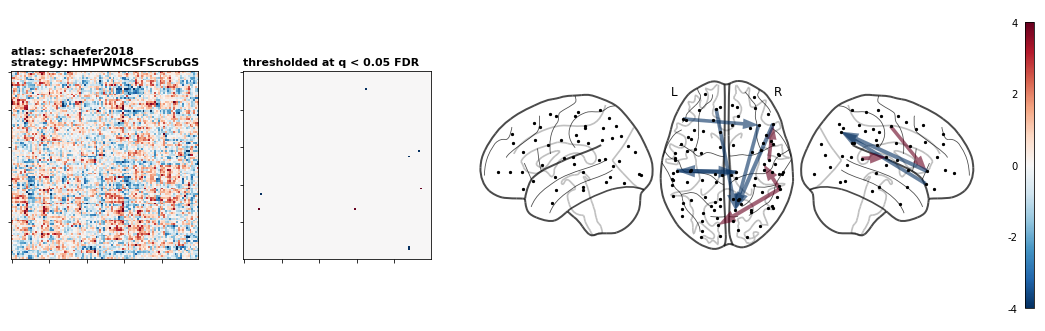

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), gridspec_kw={'width_ratios': [1, 1, 3]})
fig.tight_layout()

tmin, tmax = -4, 4
title = f'atlas: {atlas}\nstrategy: {strat}'

plotting.plot_matrix(tvals_mat, vmin=tmin, vmax=tmax, axes=axs[0], cmap=cmap, colorbar=False)

axs[0].set_title(title, fontsize=11, weight='semibold', loc='left')
axs[1].set_title('thresholded at q < 0.05 FDR', fontsize=11, weight='semibold', loc='left')

plotting.plot_matrix(tvals_sig_mat, vmin=tmin, vmax=tmax, axes=axs[1], cmap=cmap, colorbar=False)
plotting.plot_connectome(
    tvals_sig_mat, df[['x', 'y', 'z']], node_size=5, node_color='k',
    edge_cmap = cmap, edge_vmin=tmin, edge_vmax=tmax, display_mode='lzr',
    edge_kwargs={'linewidth':.1, 'alpha':.6}, axes=axs[2], colorbar=True)

fig.savefig(f'{wb_ppi}/group/atlas-{atlas}/atlas-{atlas}_strat-{strat}_static.png', dpi=300, facecolor='w')

dynamic matrix and connectome

In [51]:
df_plot = pd.DataFrame(tvals_sig_mat, index=labels, columns=labels)
dmat = px.imshow(df_plot, zmin=tmin, zmax=tmax, color_continuous_scale='RdBu_r', labels={'x': 'target', 'y': 'seed', 'color': 't-stat'})
dmat.update_layout(coloraxis_showscale=False)
dmat.update_xaxes(showticklabels=False)
dmat.update_yaxes(showticklabels=False)
dmat.write_html(f'{wb_ppi}/group/atlas-{atlas}/atlas-{atlas}_strat-{strat}_dmat.html')

dconn = plotting.view_connectome(tvals_sig_mat, df[['x', 'y', 'z']], colorbar=False, edge_cmap='RdBu_r')
dconn.save_as_html(f'{wb_ppi}/group/atlas-{atlas}/atlas-{atlas}_strat-{strat}_dconn.html')

create report.html

In [52]:
template = Path('template.html').read_text()

find = ['atlas', 'static', 'dmat', 'dconn']
replace = [
    f'{wb_ppi}/group/atlas-{atlas}/atlas-{atlas}_fig.png',
    f'{wb_ppi}/group/atlas-{atlas}/atlas-{atlas}_strat-{strat}_static.png',
    f'{wb_ppi}/group/atlas-{atlas}/atlas-{atlas}_strat-{strat}_dmat.html',
    f'{wb_ppi}/group/atlas-{atlas}/atlas-{atlas}_strat-{strat}_dconn.html']

for find, replace in zip(find, replace):
    template = template.replace(find, replace)

wb_ppi.joinpath(f'group/atlas-{atlas}/atlas-{atlas}_strat-{strat}_report.html').write_text(template)

755